In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import nibabel as nib
import psutil
%matplotlib inline
from skimage.filters import threshold_triangle as triangle
from scipy.interpolate import interp1d
from sklearn.linear_model import LassoCV

from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import ndimage

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

## Load PCA

In [3]:
# FINALLY, THIS ONE WORKS
directory = os.path.join(dataset_path, 'fly_093','func_0')
brain_file = os.path.join(directory, 'brain_zscored_green_high_pass_masked.nii')
brain_high_pass = np.array(nib.load(brain_file).get_data(), copy=True)

In [3]:
t0 = time.time()
#directory = os.path.join(dataset_path, 'fly_094','func_0', 'pca', '20200929_on_masked')
#directory = os.path.join(dataset_path, 'fly_094','func_0', 'pca', '20200922_on_high_pass_masked')
#directory = os.path.join(dataset_path, 'fly_094','func_0', 'pca', '20200907_on_smooth')

directory = os.path.join(dataset_path, 'fly_106','func_0', 'pca', '20200929_on_high_pass_masked')


file = os.path.join(directory, 'scores_(spatial).npy')
pca_spatial = np.load(file)
file = os.path.join(directory, 'loadings_(temporal).npy')
pca_loadings = np.load(file)
print('Duration: {}'.format(time.time()-t0))

Duration: 40.180394411087036


In [4]:
pca_spatial.shape

(3384, 256, 128, 49)

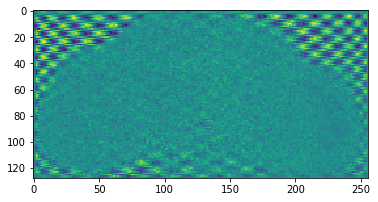

In [23]:
plt.imshow(pca_spatial[19,:,:,20].T)

In [4]:
brain_high_pass.shape

(256, 128, 49, 3384)

In [5]:
flat = brain_high_pass[:,:,20,:2000].flatten()

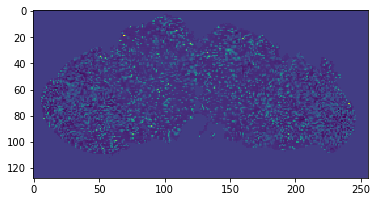

In [4]:
#green high pass mask 093
plt.imshow(brain_high_pass[:,:,20,2000].T)

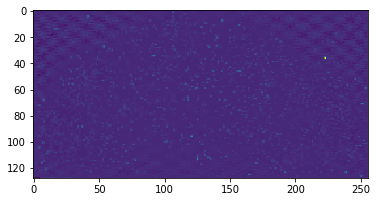

In [5]:
#green high pass mask 106
plt.imshow(brain_high_pass[:,:,20,2000].T)

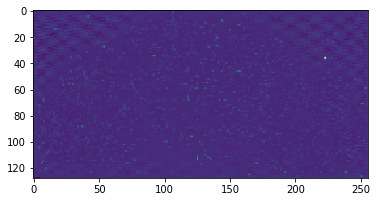

In [6]:
#green zscore 106
plt.imshow(brain_high_pass[:,:,20,2000].T)

(-5, 5)

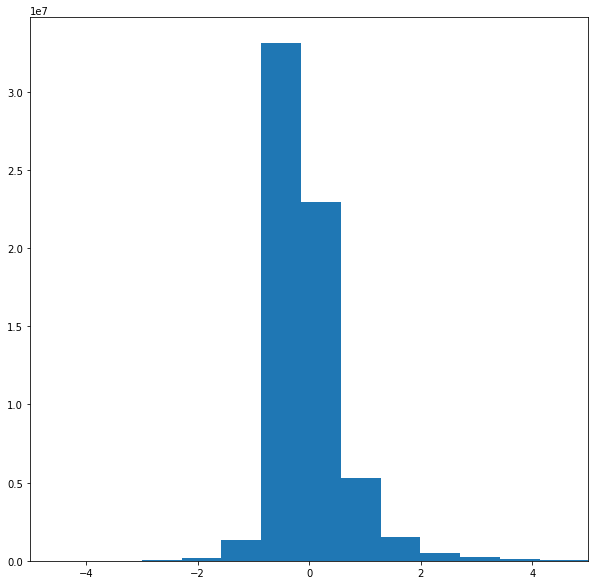

In [7]:
#green zscore high pass mask 106
fig = plt.figure(figsize=(10,10))
plt.hist(flat,bins=100);
plt.xlim(-5,5)

(-5, 5)

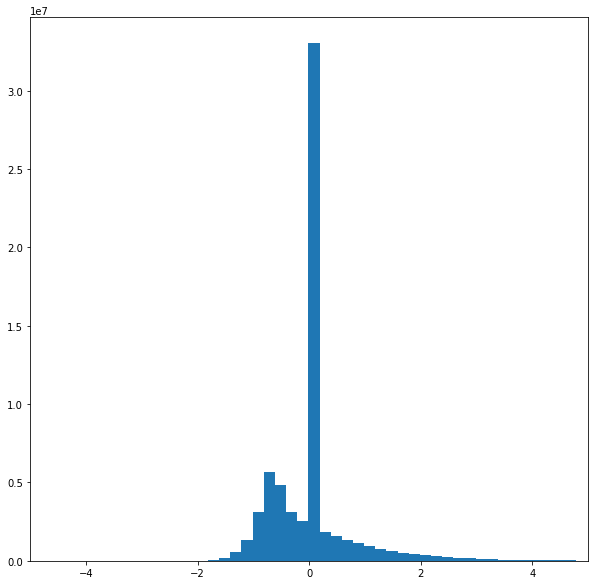

In [6]:
#green zscore high pass mask 093
fig = plt.figure(figsize=(10,10))
plt.hist(flat,bins=100);
plt.xlim(-5,5)

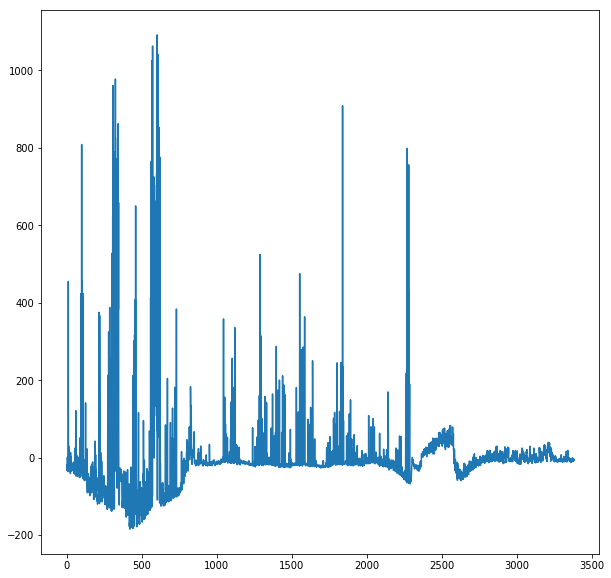

In [13]:
fig = plt.figure(figsize=(10,10))
plt.plot(pca_loadings[:,2]);
#plt.plot(fictrac_interp*1000)
#plt.xlim(1000,2000)

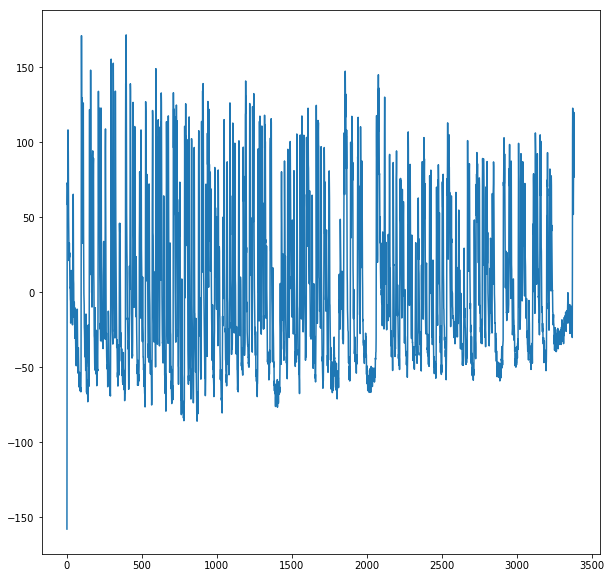

In [11]:
fig = plt.figure(figsize=(10,10))
plt.plot(pca_loadings[:,0]);
#plt.plot(fictrac_interp*1000)
#plt.xlim(1000,2000)

In [20]:
directory = os.path.join(dataset_path, 'fly_087','func_0', 'pca', '20200929_on_high_pass_masked')
file = os.path.join(directory, 'scores_(spatial).npy')
pca_spatial = np.load(file)
file = os.path.join(directory, 'loadings_(temporal).npy')
pca_loadings = np.load(file)

## Load fictrac

In [22]:
directory = os.path.join(dataset_path, 'fly_087', 'func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 46.85 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.07 sec


In [23]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=timestamps,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

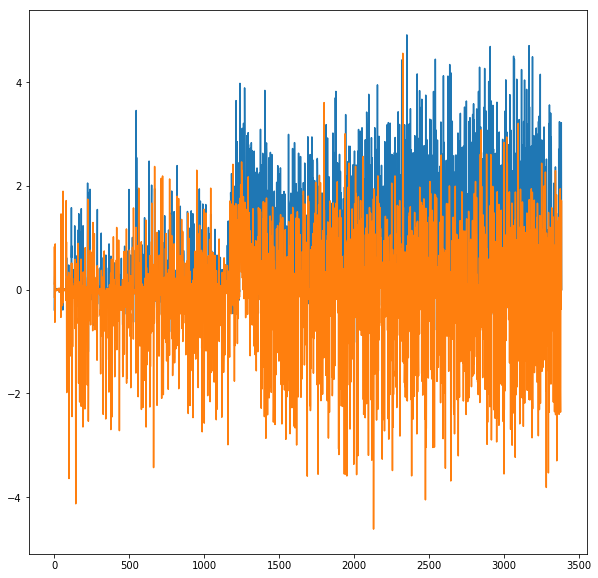

In [9]:
plt.figure(figsize=(10,10))
plt.plot(fictrac['Y'])
plt.plot(fictrac['Z'])

In [24]:
### Fit GLM ###
Y_glm = {}
Y_glm['Y'] = fictrac['Y'].copy()
Y_glm['Z'] = np.abs(fictrac['Z'].copy())

models = {}
num_pcs = 1000
for behavior in ['Y', 'Z']:
    t0 = time.time()
    models[behavior] = {'num_pcs': num_pcs, 'model': LassoCV()}
    X_glm = pca_loadings[:,:num_pcs]
    models[behavior]['model'].fit(X_glm, Y_glm[behavior])
    models[behavior]['score'] = models[behavior]['model'].score(X_glm, Y_glm[behavior])

In [25]:
coef = models['Y']['model'].coef_
spatial_map = np.tensordot(coef, pca_spatial[:1000,:,:,:],axes=1)

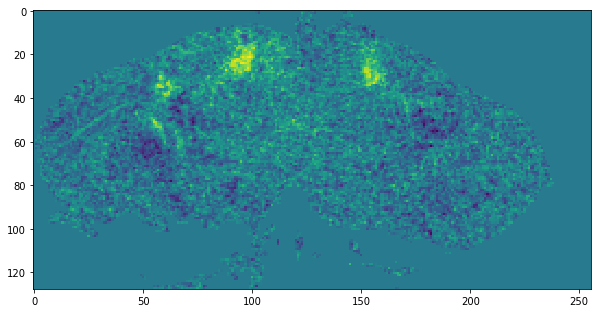

In [26]:
fig = plt.figure(figsize=(10,10))
i=15
plt.imshow(spatial_map[:,:,i].T)

In [12]:
#Y_glm = np.clip(fictrac['Y'],0,None)
Y_glm = fictrac['Y'].copy()
#super_threshold_indices = fictrac['Y'] > 1
#Y_glm = Y_glm[super_threshold_indices]
Y_glm = np.abs(fictrac['Z'].copy())


models = []
for num_pcs in [10,100,1000]:
    t0 = time.time()
    models.append({'num_pcs': num_pcs, 'model': LassoCV(), 'model_type': 'LassoLarsIC'})
    X_glm = pca_loadings[:,:num_pcs]
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time.time()-t0))

Num PCs: 10, Duration: 0.06643795967102051 sec
Num PCs: 100, Duration: 0.11488175392150879 sec
Num PCs: 1000, Duration: 2.5025455951690674 sec


In [6]:
#Y_glm = np.clip(fictrac['Y'],0,None)
Y_glm = fictrac['Y'].copy()
#super_threshold_indices = fictrac['Y'] > 1
#Y_glm = Y_glm[super_threshold_indices]
#Y_glm = np.log(Y_glm)

models = []
for num_pcs in [10,100,1000]:
    t0 = time.time()
    models.append({'num_pcs': num_pcs, 'model': LassoCV(), 'model_type': 'LassoLarsIC'})
    X_glm = pca_loadings[super_threshold_indices,:num_pcs]
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time.time()-t0))

NameError: name 'super_threshold_indices' is not defined

In [94]:
np.log(.9)

-0.10536051565782628

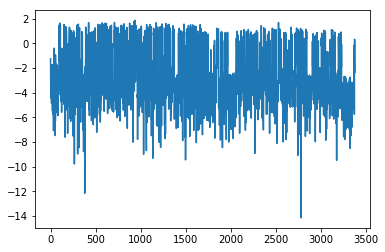

In [90]:
plt.plot(np.log(np.abs(fictrac['Y'])))

In [36]:
### Save scores ###
score_file = os.path.join(directory, 'test.txt')
with open(score_file, "a") as f:
    f.write("{}:{}\n".format('Z', 0.22))

In [29]:
score_file

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_087/func_0/test.txt'

Text(0.5, 0.98, 'Regularization: LassoLarsIC(BIC)')

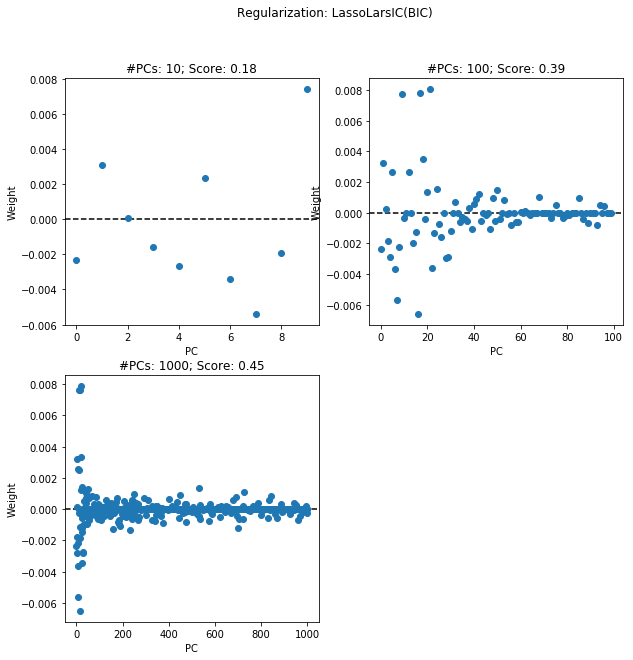

In [13]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

In [95]:
len(models[2]['model'].coef_)

1000

In [96]:
pca_spatial.shape

(3384, 256, 128, 49)

In [14]:
coef = models[2]['model'].coef_
spatial_map = np.tensordot(coef, pca_spatial[:1000,:,:,:],axes=1)

In [46]:
spatial_map_1up = spatial_map.copy()

In [98]:
spatial_map_Y.shape

(256, 128, 49)

In [12]:
file = os.path.join(dataset_path, 'fly_094','func_0', 'temp_forward_mask_only.nii')
nib.Nifti1Image(spatial_map, np.eye(4)).to_filename(file)

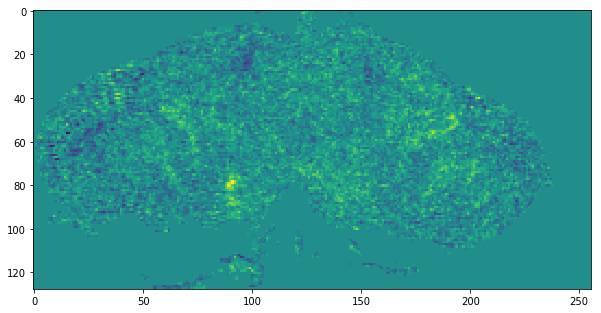

In [19]:
fig = plt.figure(figsize=(10,10))
i=15
plt.imshow(spatial_map[:,:,i].T)

In [ ]:
an r2 of .6 would be an r of .77
an r2 of .1 would be an r of .31
Basically, r is always bigger
so, reporting r makes you sound fancier.
But indeed it is really r2!!

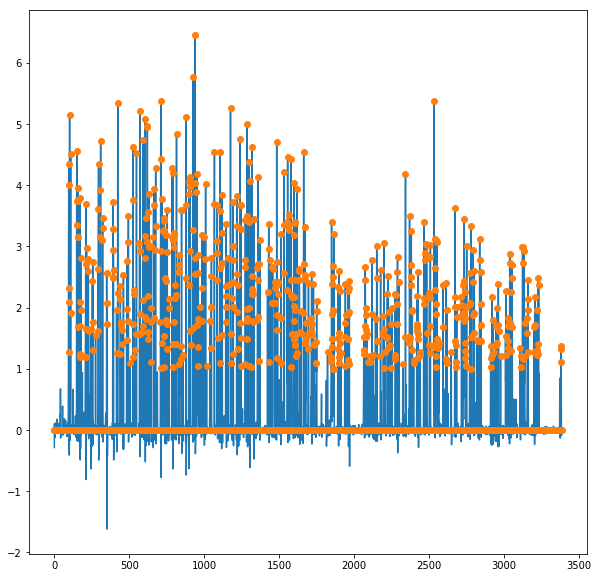

In [38]:
plt.figure(figsize=(10,10))

Y_glm = fictrac['Y'].copy()
super_threshold_indices = fictrac['Y'] < 1
Y_glm[super_threshold_indices] = 0


plt.plot(fictrac['Y'])
plt.plot(Y_glm,'o')
#plt.plot(models[0]['model'].predict(pca_loadings[:,:10]))
#plt.plot(models[2]['model'].predict(pca_loadings[:,:1000]))
#plt.xlim(0,1400)

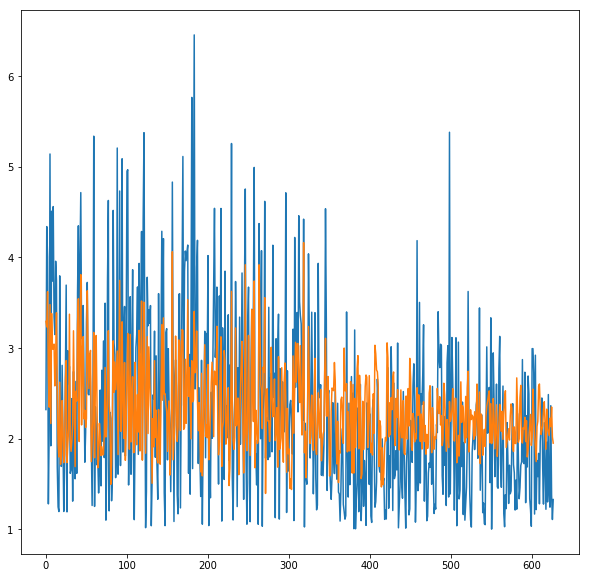

In [62]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
#plt.plot(models[0]['model'].predict(pca_loadings[:,:10]))
plt.plot(models[2]['model'].predict(pca_loadings[super_threshold_indices,:1000]))
#plt.xlim(0,1400)

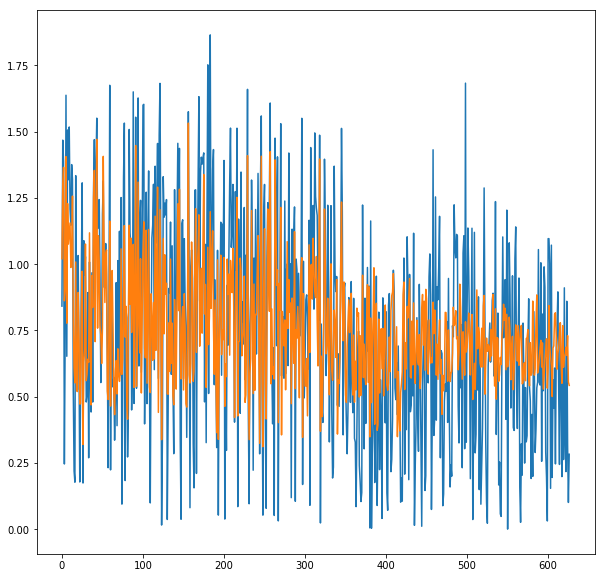

In [82]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
#plt.plot(models[0]['model'].predict(pca_loadings[:,:10]))
plt.plot(models[2]['model'].predict(pca_loadings[super_threshold_indices,:1000]))
#plt.xlim(0,1400)

In [84]:
prediction = models[2]['model'].predict(pca_loadings[super_threshold_indices,:1000])

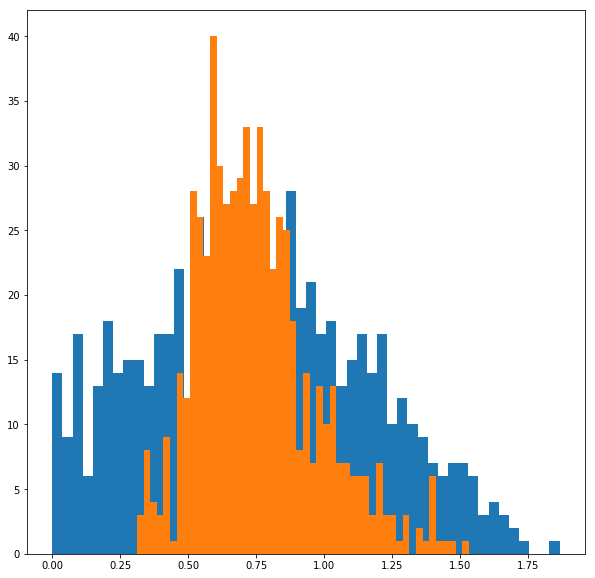

In [85]:
plt.figure(figsize=(10,10))
plt.hist(Y_glm,bins=50);
plt.hist(prediction,bins=50);

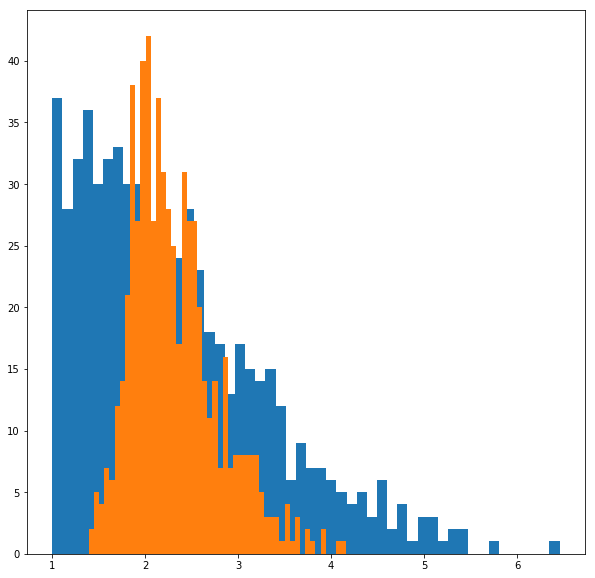

In [74]:
plt.figure(figsize=(10,10))
plt.hist(Y_glm,bins=50);
plt.hist(prediction,bins=50);

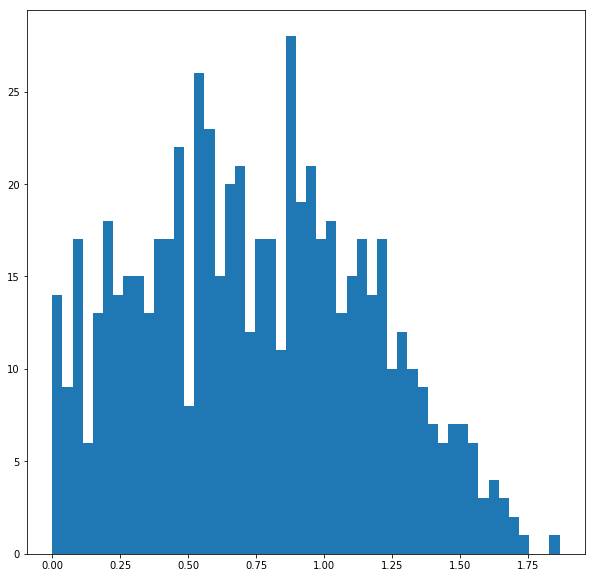

In [79]:
plt.figure(figsize=(10,10))
plt.hist(np.log(Y_glm),bins=50);